# Road Sign Classification with MobileNetV2

This notebook trains a MobileNetV2 model on the RoadSaW dataset for traffic sign classification.

## 1. Setup and Data Loading

In [ ]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from collections import Counter

# Paths to dataset (data from google drive)
train_dir = "/content/drive/MyDrive/datasets/RoadSaW-075_s/train"
val_dir   = "/content/drive/MyDrive/datasets/RoadSaW-075_s/validation"
test_dir  = "/content/drive/MyDrive/datasets/RoadSaW-075_s/test"

# Image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),    # ±10% translation
        scale=(0.9, 1.1),        # 90% to 110% scaling
        shear=10                 # ±10 degrees shear
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# For validation and test, use only resizing and normalization (no random augmentations)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)), \
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder (assumes subdirectories per class)
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_transform)

# Compute class frequencies in the training set for balanced sampling
class_counts = Counter(train_dataset.targets)  # count of each class index in training data
num_classes = len(train_dataset.classes)       # 12 for our RoadSaW dataset

# Create a weight for each sample: inverse of its class frequency
sample_weights = [1.0 / class_counts[label] for label in train_dataset.targets]

# Define the weighted sampler for balanced class sampling
sampler = WeightedRandomSampler(weights=sample_weights,
                               num_samples=len(train_dataset),
                               replacement=True)

# Create DataLoaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Model Definition

In [ ]:
import torch.nn as nn
from torchvision import models

# Load MobileNetV2 pretrained on ImageNet and modify the classifier for custom classes
# Fixed: Use updated API for loading pretrained model
try:
    # For newer PyTorch versions
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
except TypeError:
    # Fallback for older PyTorch versions
    model = models.mobilenet_v2(pretrained=True)

# Modify the classifier for our number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Freeze backbone layers (feature extractor) for initial training phase
for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)
print(f"Model initialized with {num_classes} output classes")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 136MB/s]


Model initialized with 12 output classes


## 3. Optimizer and Loss Function

In [ ]:
import torch.optim as optim

# Setup loss function and optimizer for phase 1
criterion = nn.CrossEntropyLoss()

# Fixed: Use standard Adam optimizer instead of RAdam if not available
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

# Learning rate scheduler: decay LR by 0.9 every epoch
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

print("Optimizer and loss function initialized")

Optimizer and loss function initialized


## 4. Training Loop

In [ ]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass + optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Print every N batches
        if batch_idx % 10 == 0:
            print(f"  Batch {batch_idx}/{len(loader)} - "
                  f"Loss: {loss.item():.4f}")

    return running_loss / total, running_correct / total

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track statistics
            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, running_correct / total

# Training for more epochs
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs} - Training Phase")

    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Update learning rate
    scheduler.step()
    print(f"Learning rate: {scheduler.get_last_lr()[0]:.6f}")


Epoch 1/5 - Training Phase
  Batch 0/485 - Loss: 2.5484
  Batch 10/485 - Loss: 2.5087
  Batch 20/485 - Loss: 2.4909
  Batch 30/485 - Loss: 2.5397
  Batch 40/485 - Loss: 2.4424
  Batch 50/485 - Loss: 2.4838
  Batch 60/485 - Loss: 2.3767
  Batch 70/485 - Loss: 2.3296
  Batch 80/485 - Loss: 2.3478
  Batch 90/485 - Loss: 2.3380
  Batch 100/485 - Loss: 2.2583
  Batch 110/485 - Loss: 2.3435
  Batch 120/485 - Loss: 2.2291
  Batch 130/485 - Loss: 2.2124
  Batch 140/485 - Loss: 2.1767
  Batch 150/485 - Loss: 2.1708
  Batch 160/485 - Loss: 2.1620
  Batch 170/485 - Loss: 2.1030
  Batch 180/485 - Loss: 1.9925
  Batch 190/485 - Loss: 2.0936
  Batch 200/485 - Loss: 2.1258
  Batch 210/485 - Loss: 2.0833
  Batch 220/485 - Loss: 1.8951
  Batch 230/485 - Loss: 2.0274
  Batch 240/485 - Loss: 1.9787
  Batch 250/485 - Loss: 1.9051
  Batch 260/485 - Loss: 1.9873
  Batch 270/485 - Loss: 1.9297
  Batch 280/485 - Loss: 1.9237
  Batch 290/485 - Loss: 1.9288
  Batch 300/485 - Loss: 1.8662
  Batch 310/485 - Loss

## 5. Test Set Evaluation

🔍 Evaluating model on test set...

Batch 1: Loss = 1.2620, Correct = 22/32
Batch 2: Loss = 0.5242, Correct = 32/32
Batch 3: Loss = 1.5517, Correct = 11/32
Batch 4: Loss = 0.8954, Correct = 26/32
Batch 5: Loss = 1.2272, Correct = 16/32
Batch 6: Loss = 1.6694, Correct = 0/32
Batch 7: Loss = 1.2599, Correct = 8/32
Batch 8: Loss = 0.5659, Correct = 32/32
Batch 9: Loss = 1.3194, Correct = 18/32
Batch 10: Loss = 3.7679, Correct = 0/32
Batch 11: Loss = 3.7167, Correct = 0/32
Batch 12: Loss = 4.4804, Correct = 0/32
Batch 13: Loss = 3.9828, Correct = 0/32
Batch 14: Loss = 1.2393, Correct = 17/32
Batch 15: Loss = 3.0632, Correct = 6/32
Batch 16: Loss = 0.5679, Correct = 29/32
Batch 17: Loss = 0.3695, Correct = 32/32
Batch 18: Loss = 0.4198, Correct = 32/32
Batch 19: Loss = 0.8412, Correct = 22/32
Batch 20: Loss = 0.8295, Correct = 23/32
Batch 21: Loss = 0.7587, Correct = 29/32
Batch 22: Loss = 0.9129, Correct = 25/32
Batch 23: Loss = 1.1159, Correct = 21/32
Batch 24: Loss = 0.9918, Correct = 15/

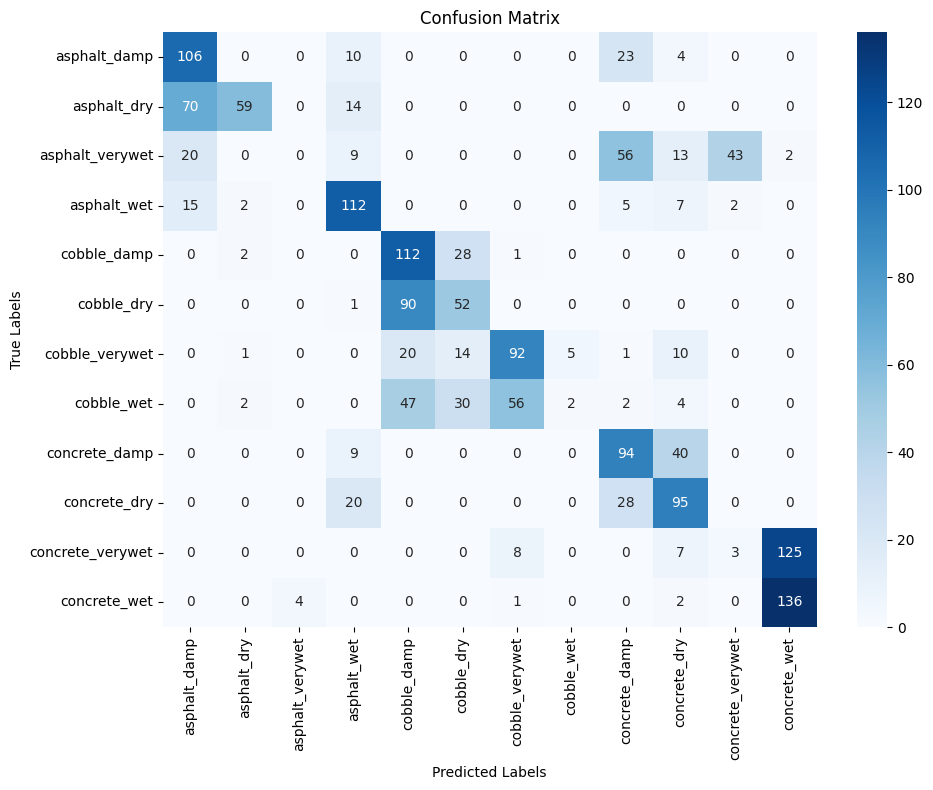

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
all_preds = []
all_labels = []

print("🔍 Evaluating model on test set...\n")
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, preds = outputs.max(1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        print(f"Batch {batch_idx+1}: Loss = {loss.item():.4f}, "
              f"Correct = {(preds == labels).sum().item()}/{labels.size(0)}")

# Compute metrics
test_loss /= test_total
test_acc = test_correct / test_total

print("\n✅ Evaluation Complete.")
print(f"📉 Average Test Loss: {test_loss:.4f}")
print(f"🎯 Test Accuracy: {test_acc:.4%}")

# Classification Report with actual class names
print("\n📊 Classification Report:")
target_names = train_dataset.classes  # Use actual class names
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

# Confusion Matrix
print("\n🧾 Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## 6. Save Model

In [ ]:
# Save the trained model
model_path = 'roadsign_mobilenetv2.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': train_dataset.class_to_idx,
    'num_classes': num_classes
}, model_path)

print(f"Model saved to {model_path}")